In [1]:
# Import modules

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as si

import astropy.constants as con
import astropy.units as unt

import pymsg

# Set constants

C = con.c.cgs.value
PC = con.pc.cgs.value

# Set plot parameters

plt.rcParams.update({'font.size': 12})

In [2]:
def synthesize_irradiance(specgrid, lam, bruce_file, d):
    
    # Read the BRUCE file

    with si.FortranFile(bruce_file, 'r') as f:
        
        # Read header
        
        record = f.read_record('<i4', '<f4')
    
        n_vis = record[0][0]
        time = record[1][0]
        
        # Read quadrature element data, converting to cgs units

        Teff = np.empty(n_vis)
        logg = np.empty(n_vis)
        v_proj = np.empty(n_vis)
        dA_proj = np.empty(n_vis)
        mu = np.empty(n_vis)
    
        for i in range(n_vis):
            
            Teff[i], v_proj[i], dA_proj[i], g, mu[i] = f.read_reals('<f4')

            v_proj[i] *= -1e2
            dA_proj[i] *= 1e4
            logg[i] = np.log10(g) + 2

    # Evaluate dOmega (solid angle) and z (redshift) 

    dOmega = dA_proj/(d*PC)**2
    z = v_proj/C

    # Set up photospheric parameters

    x = {'Teff': Teff, 'log(g)': logg}

    # Synthesize the irradiance

    F_lam_obs = specgrid.irradiance(x, mu, dOmega, z, lam)

    # Return the time and irradiance
    
    return time, F_lam_obs

In [3]:
# Create the SpecGrid object

specgrid = pymsg.SpecGrid('sg-HeI-6678.h5')

# Set up parameters (the choice of distance is arbitrary)

d = 10

n_time = 20

# Set up the wavelength abscissa

lam = np.linspace(6670, 6690, 201)
lam_c = 0.5*(lam[:-1] + lam[1:])

# Evaluate the irradiance spectra

time = []
F_lam_obs = []

for i in range(n_time):
    
    bruce_file = f'elements-{i+1:03d}'
    
    result = synthesize_irradiance(specgrid, lam, bruce_file, d)

    time += [result[0]]
    F_lam_obs += [result[1]]

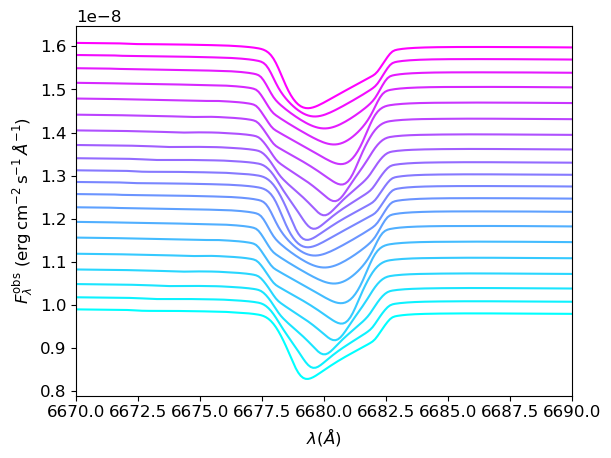

In [4]:
# Plot the irradiance spectra

plt.figure()

cmap = mpl.colormaps['cool']

offset=0.2*(np.max(F_lam_obs[0]) - np.min(F_lam_obs[0]))

for i in range(n_time):
    
    plt.plot(lam_c, F_lam_obs[i]+i*offset, color=cmap(i/(n_time-1)))

plt.xlim(6670, 6690)

plt.xlabel(r'$\lambda ({\AA})$')
plt.ylabel(r'$F^{\mathrm{obs}}_{\lambda}\ ({\rm erg\,cm^{-2}\,s^{-1}}\,\AA^{-1})$');